# How to train your DragoNN tutorial 5: 
## CNN Hyperparameter Tuning via Grid Search 
This tutorial is a supplement to the DragoNN manuscript and follows figure 6 in the manuscript. 

This tutorial will take 30 minutes - 1 hour if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Define default CNN architecture helper utilities</a></li> 
    <li><a href=#3>Data simulation and default CNN model performance</a></li>
    <ol>
        <li><a href=#3a>Simple Motif Detection: TAL1, CTCF, ZNF143, SIX5 </a></li>
        <li><a href=#3b>Motif Density Detection</a></li>
        <li><a href=#3c>Motif Density Localization</a></li>
        <li><a href=#3d>Multiple Motif Detection</a></li>
        <li><a href=#3e>Heterodimer Motif Grammar: SPI1_IRF</a></li>
    </ol>
    <li><a href=#4>Hyperparameter grid search</a></li>
    <ol>
    <li><a href=#4a>Training examples</a></li>
    <li><a href=#4b>Convolutional Filter Width </a></li>  
    <li><a href=#4c>Number of convolution filters</a></li>
    <li><a href=#4d>Max Pooling Width</a></li>
    </ol>
    <li><a href=#5>Conclusions</a></li>
</ol>

Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./primer_tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./primer_tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./primer_tutorial_images/inspecting_code.png)


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [2]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *


Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Define basic CNN architecture helper utilities <a name='2'>
<a href=#outline>Home</a>


We start with a simple reference CNN architecture that contains a convolutional layer with 10 convolutional filters (size 15, stride 1) and ReLU activations, followed by max-pooling (size 35,stride 35), followed by a fully connected layer with a logistic output neuron for binary classification. Models are trained using the Adam optimizer with early stopping after 7 consecutive epochs without validation loss improvement. Performance (auROC) is recorded on an the independent test set.

We will initialize multiple models with this basic architecture, so we write helper functions to generate the architecture, perform training, print the loss curve, and print test set auROC. 

In [4]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


In [5]:
def build_default_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model 


In [6]:
from dragonn.callbacks import * 
def train_default_model(data,num_tasks,model_constructor=build_default_model):
    
    #Build the model 
    model=model_constructor(data.X_train.shape[1::],num_tasks)
    
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),
                                 validation_data=(data.X_valid,data.y_valid))
    #Train the Model
    history=model.fit(x=data.X_train,y=data.y_train,
                      batch_size=128,
                      epochs=150,
                      verbose=0,
                      callbacks=[EarlyStopping(patience=7),
                                 History(),
                                 metrics_callback],
                      validation_data=(data.X_valid,data.y_valid))
    #Plot the learning curve
    plot_learning_curve(history)
    
    #Print model performance on held-out test set
    print("Test Set Performance:")
    test_predictions=model.predict(data.X_test)
    print(ClassificationResult(data.y_test,test_predictions))

    #return the trained model and history 
    return model,history


## Data simulation and basic architecture performance <a name='2'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [7]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


We design four single-task binary classification tasks using DNA sequences that simulate different
properties of regulatory DNA sequences: single motif, homotypic motif clusters, heterotypic motif
clusters, and heterodimer motif grammars with spatial constraints. We further design a multitask
classification simulation to jointly detect motif instances of 3 distinct TFs (corresponding to 3 binary
classification tasks, one per TF). In each simulation, we embed motif instances with the relevant
constraints in random sequences (G/C frequency = 0.4). We hold out 20% of sequences for a test
set, 16% for a validation set, and use the remaining sequences for training. Motif instances are
reverse complemented with 0.5 probability before they are embedded in the background sequence.

We train models with the default architecture for these 4 individual TF simulations and evaluate the models' performance: 

### Simple Motif Detection: 

TAL1_Known4: 
![play button](./primer_tutorial_images/TAL1_known4.png)

Training Data:
Loss: 0.6930	Balanced Accuracy: 51.91%	 auROC: 0.526	 auPRC: 0.517
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6977	Balanced Accuracy: 49.88%	 auROC: 0.501	 auPRC: 0.499
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.6897	Balanced Accuracy: 53.08%	 auROC: 0.546	 auPRC: 0.533
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6964	Balanced Accuracy: 50.81%	 auROC: 0.507	 auPRC: 0.505
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.6871	Balanced Accuracy: 54.23%	 auROC: 0.563	 auPRC: 0.549
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.6956	Balanced Accuracy: 51.03%	 auROC: 0.511	 auPRC: 0.509
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1600	 Num Negatives: 160

Training Data:
Loss: 0.4526	Balanced Accuracy: 83.28%	 auROC: 0.898	 auPRC: 0.879
	Recall at 5%|10%|20% FDR: 0.4%|51.9%|87.8%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.4599	Balanced Accuracy: 82.12%	 auROC: 0.892	 auPRC: 0.882
	Recall at 5%|10%|20% FDR: 16.2%|49.6%|85.9%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.4447	Balanced Accuracy: 82.37%	 auROC: 0.903	 auPRC: 0.885
	Recall at 5%|10%|20% FDR: 3.3%|58.4%|89.2%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.4525	Balanced Accuracy: 81.53%	 auROC: 0.898	 auPRC: 0.888
	Recall at 5%|10%|20% FDR: 21.1%|57.4%|87.8%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.4320	Balanced Accuracy: 84.45%	 auROC: 0.906	 auPRC: 0.888
	Recall at 5%|10%|20% FDR: 3.1%|59.7%|89.9%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.4385	Balanced Accuracy: 83.81%	 auROC: 0.901	 auPRC: 0.891
	Recall at 5%|10%|20% FDR: 22.3%|59.9%|89.4%	 Num Positives: 1600	 Num

Training Data:
Loss: 0.3147	Balanced Accuracy: 89.28%	 auROC: 0.941	 auPRC: 0.931
	Recall at 5%|10%|20% FDR: 60.4%|88.0%|94.9%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3249	Balanced Accuracy: 88.84%	 auROC: 0.936	 auPRC: 0.932
	Recall at 5%|10%|20% FDR: 59.9%|87.4%|93.6%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.3122	Balanced Accuracy: 89.42%	 auROC: 0.942	 auPRC: 0.932
	Recall at 5%|10%|20% FDR: 62.3%|88.3%|95.0%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3225	Balanced Accuracy: 89.31%	 auROC: 0.936	 auPRC: 0.933
	Recall at 5%|10%|20% FDR: 60.2%|88.1%|93.9%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.3123	Balanced Accuracy: 89.54%	 auROC: 0.942	 auPRC: 0.932
	Recall at 5%|10%|20% FDR: 62.3%|88.4%|94.9%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3224	Balanced Accuracy: 89.19%	 auROC: 0.936	 auPRC: 0.933
	Recall at 5%|10%|20% FDR: 60.7%|88.0%|93.7%	 Num Positives: 1600	 

Training Data:
Loss: 0.2893	Balanced Accuracy: 90.02%	 auROC: 0.948	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 68.6%|90.6%|95.3%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3079	Balanced Accuracy: 89.44%	 auROC: 0.938	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 65.9%|90.2%|93.9%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2878	Balanced Accuracy: 90.35%	 auROC: 0.948	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 69.0%|90.6%|95.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3067	Balanced Accuracy: 89.84%	 auROC: 0.938	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 65.9%|90.2%|94.0%	 Num Positives: 1600	 Num Negatives: 1600
Training Data:
Loss: 0.2877	Balanced Accuracy: 90.35%	 auROC: 0.948	 auPRC: 0.940
	Recall at 5%|10%|20% FDR: 68.7%|90.6%|95.4%	 Num Positives: 6355	 Num Negatives: 6445
Validation Data:
Loss: 0.3068	Balanced Accuracy: 90.00%	 auROC: 0.938	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 65.6%|90.1%|93.9%	 Num Positives: 1600	 

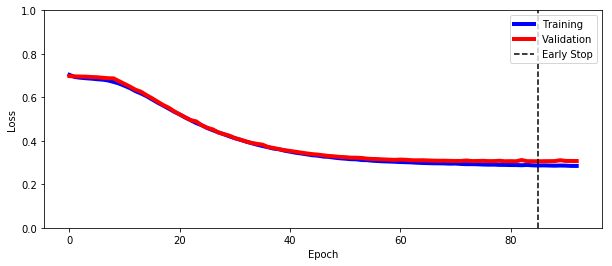

Test Set Performance:
Loss: 0.3369	Balanced Accuracy: 88.48%	 auROC: 0.929	 auPRC: 0.921
	Recall at 5%|10%|20% FDR: 30.3%|85.9%|94.1%	 Num Positives: 2045	 Num Negatives: 1955


In [8]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
tal1_default_model,tal1_default_history=train_default_model(tal1_data,1)

CTCF_Known1: 
![play button](./primer_tutorial_images/CTCF_known1.png)

Training Data:
Loss: 0.6965	Balanced Accuracy: 51.24%	 auROC: 0.527	 auPRC: 0.522
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.7010	Balanced Accuracy: 50.52%	 auROC: 0.508	 auPRC: 0.513
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.6875	Balanced Accuracy: 54.37%	 auROC: 0.562	 auPRC: 0.554
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.5%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.6951	Balanced Accuracy: 51.74%	 auROC: 0.522	 auPRC: 0.526
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.6804	Balanced Accuracy: 56.79%	 auROC: 0.606	 auPRC: 0.598
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.3%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.6895	Balanced Accuracy: 52.58%	 auROC: 0.554	 auPRC: 0.557
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 1613	 Num Negatives: 158

Training Data:
Loss: 0.2710	Balanced Accuracy: 89.68%	 auROC: 0.954	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 82.6%|89.1%|94.2%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.3093	Balanced Accuracy: 88.07%	 auROC: 0.933	 auPRC: 0.949
	Recall at 5%|10%|20% FDR: 77.9%|86.1%|91.9%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.2674	Balanced Accuracy: 89.98%	 auROC: 0.955	 auPRC: 0.963
	Recall at 5%|10%|20% FDR: 83.4%|89.5%|94.3%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.3057	Balanced Accuracy: 88.07%	 auROC: 0.934	 auPRC: 0.950
	Recall at 5%|10%|20% FDR: 79.2%|86.8%|92.1%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.2637	Balanced Accuracy: 90.09%	 auROC: 0.955	 auPRC: 0.964
	Recall at 5%|10%|20% FDR: 83.7%|89.7%|94.4%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.3025	Balanced Accuracy: 88.41%	 auROC: 0.935	 auPRC: 0.951
	Recall at 5%|10%|20% FDR: 79.1%|86.7%|92.2%	 Num Positives: 1613	 

Training Data:
Loss: nan	Balanced Accuracy: 92.89%	 auROC: 0.970	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 90.5%|93.1%|95.8%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.2577	Balanced Accuracy: 90.84%	 auROC: 0.947	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 86.2%|90.2%|92.7%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: nan	Balanced Accuracy: 92.96%	 auROC: 0.970	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 90.5%|93.2%|95.9%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.2579	Balanced Accuracy: 90.97%	 auROC: 0.947	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 86.5%|90.3%|92.7%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: nan	Balanced Accuracy: 93.04%	 auROC: 0.971	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 90.7%|93.3%|95.9%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: 0.2573	Balanced Accuracy: 91.00%	 auROC: 0.947	 auPRC: 0.962
	Recall at 5%|10%|20% FDR: 86.5%|90.4%|92.9%	 Num Positives: 1613	 Num Negat

Training Data:
Loss: nan	Balanced Accuracy: 93.54%	 auROC: 0.975	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 91.9%|94.0%|96.4%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: nan	Balanced Accuracy: 91.07%	 auROC: 0.949	 auPRC: 0.964
	Recall at 5%|10%|20% FDR: 86.7%|90.2%|93.0%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: nan	Balanced Accuracy: 93.78%	 auROC: 0.975	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 92.0%|94.1%|96.4%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: nan	Balanced Accuracy: 91.12%	 auROC: 0.949	 auPRC: 0.964
	Recall at 5%|10%|20% FDR: 86.6%|90.3%|93.1%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: nan	Balanced Accuracy: 93.75%	 auROC: 0.975	 auPRC: 0.981
	Recall at 5%|10%|20% FDR: 92.0%|94.0%|96.4%	 Num Positives: 6385	 Num Negatives: 6415
Validation Data:
Loss: nan	Balanced Accuracy: 91.09%	 auROC: 0.949	 auPRC: 0.964
	Recall at 5%|10%|20% FDR: 86.4%|90.1%|93.1%	 Num Positives: 1613	 Num Negatives: 158

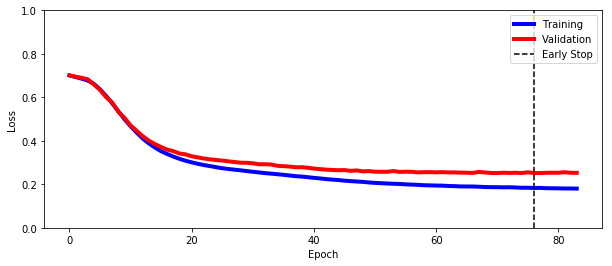

Test Set Performance:
Loss: nan	Balanced Accuracy: 92.58%	 auROC: 0.958	 auPRC: 0.970
	Recall at 5%|10%|20% FDR: 90.0%|92.5%|94.4%	 Num Positives: 2002	 Num Negatives: 1998


In [9]:
#Define simulation parameters 
ctcf_parameters = {
    "motif_name": "CTCF_known1",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
ctcf_data = get_simulation_data("simulate_single_motif_detection",
                                      ctcf_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
ctcf_default_model,ctcf_default_history=train_default_model(ctcf_data,1)

ZNF143_known2: 
![play button](./primer_tutorial_images/ZNF143_known2.png)

Training Data:
Loss: 0.6985	Balanced Accuracy: 51.21%	 auROC: 0.534	 auPRC: 0.529
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.7022	Balanced Accuracy: 50.57%	 auROC: 0.513	 auPRC: 0.510
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.6901	Balanced Accuracy: 53.39%	 auROC: 0.570	 auPRC: 0.564
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.3%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.6955	Balanced Accuracy: 50.77%	 auROC: 0.533	 auPRC: 0.528
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.6780	Balanced Accuracy: 58.35%	 auROC: 0.614	 auPRC: 0.615
	Recall at 5%|10%|20% FDR: 0.7%|0.7%|2.3%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.6860	Balanced Accuracy: 54.85%	 auROC: 0.569	 auPRC: 0.567
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.3%	 Num Positives: 1601	 Num Negatives: 159

Training Data:
Loss: 0.3365	Balanced Accuracy: 88.56%	 auROC: 0.943	 auPRC: 0.949
	Recall at 5%|10%|20% FDR: 76.1%|86.8%|93.2%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.3571	Balanced Accuracy: 87.50%	 auROC: 0.931	 auPRC: 0.938
	Recall at 5%|10%|20% FDR: 69.8%|84.8%|92.3%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.3282	Balanced Accuracy: 88.78%	 auROC: 0.945	 auPRC: 0.951
	Recall at 5%|10%|20% FDR: 77.5%|87.4%|93.4%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.3492	Balanced Accuracy: 87.78%	 auROC: 0.934	 auPRC: 0.941
	Recall at 5%|10%|20% FDR: 71.8%|85.4%|92.6%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.3194	Balanced Accuracy: 88.97%	 auROC: 0.947	 auPRC: 0.954
	Recall at 5%|10%|20% FDR: 79.6%|88.0%|93.5%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.3391	Balanced Accuracy: 88.16%	 auROC: 0.936	 auPRC: 0.943
	Recall at 5%|10%|20% FDR: 74.0%|86.6%|92.9%	 Num Positives: 1601	 

Training Data:
Loss: 0.2023	Balanced Accuracy: 94.05%	 auROC: 0.972	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 92.4%|94.1%|96.0%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2315	Balanced Accuracy: 92.56%	 auROC: 0.961	 auPRC: 0.970
	Recall at 5%|10%|20% FDR: 89.8%|93.1%|94.9%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.1982	Balanced Accuracy: 94.17%	 auROC: 0.973	 auPRC: 0.979
	Recall at 5%|10%|20% FDR: 92.7%|94.2%|96.1%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2276	Balanced Accuracy: 93.06%	 auROC: 0.961	 auPRC: 0.971
	Recall at 5%|10%|20% FDR: 90.8%|93.4%|94.9%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.1947	Balanced Accuracy: 94.17%	 auROC: 0.974	 auPRC: 0.980
	Recall at 5%|10%|20% FDR: 92.9%|94.3%|96.1%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.2256	Balanced Accuracy: 92.78%	 auROC: 0.962	 auPRC: 0.971
	Recall at 5%|10%|20% FDR: 91.1%|93.4%|94.9%	 Num Positives: 1601	 

Training Data:
Loss: 0.1476	Balanced Accuracy: 95.44%	 auROC: 0.981	 auPRC: 0.986
	Recall at 5%|10%|20% FDR: 94.1%|95.2%|97.3%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.1824	Balanced Accuracy: 94.81%	 auROC: 0.966	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 93.5%|93.9%|95.3%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.1476	Balanced Accuracy: 95.57%	 auROC: 0.982	 auPRC: 0.986
	Recall at 5%|10%|20% FDR: 94.1%|95.3%|97.3%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.1803	Balanced Accuracy: 95.13%	 auROC: 0.966	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 93.5%|94.0%|95.2%	 Num Positives: 1601	 Num Negatives: 1599
Training Data:
Loss: 0.1476	Balanced Accuracy: 95.37%	 auROC: 0.982	 auPRC: 0.986
	Recall at 5%|10%|20% FDR: 94.1%|95.3%|97.3%	 Num Positives: 6426	 Num Negatives: 6374
Validation Data:
Loss: 0.1844	Balanced Accuracy: 94.69%	 auROC: 0.966	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 93.4%|94.0%|95.3%	 Num Positives: 1601	 

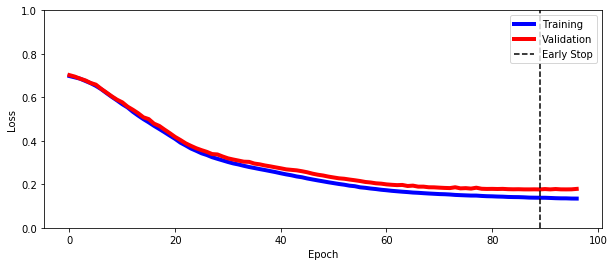

Test Set Performance:
Loss: 0.1855	Balanced Accuracy: 94.35%	 auROC: 0.966	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 92.7%|93.3%|94.9%	 Num Positives: 1973	 Num Negatives: 2027


In [10]:
#Define simulation parameters 
znf143_parameters={
    "motif_name": "ZNF143_known2",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data 
znf143_data=get_simulation_data("simulate_single_motif_detection",
                               znf143_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
znf143_default_model,znf143_default_history=train_default_model(znf143_data,1)

SIX5_known1:  
![play button](./primer_tutorial_images/SIX5_known1.png) 

Training Data:
Loss: 0.6944	Balanced Accuracy: 51.45%	 auROC: 0.521	 auPRC: 0.514
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.6990	Balanced Accuracy: 49.67%	 auROC: 0.500	 auPRC: 0.526
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.6915	Balanced Accuracy: 52.87%	 auROC: 0.542	 auPRC: 0.531
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.6989	Balanced Accuracy: 50.29%	 auROC: 0.504	 auPRC: 0.530
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.6878	Balanced Accuracy: 54.30%	 auROC: 0.560	 auPRC: 0.548
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.6946	Balanced Accuracy: 50.00%	 auROC: 0.510	 auPRC: 0.534
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1669	 Num Negatives: 153

Training Data:
Loss: 0.4993	Balanced Accuracy: 78.76%	 auROC: 0.854	 auPRC: 0.842
	Recall at 5%|10%|20% FDR: 9.4%|31.0%|75.8%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.5401	Balanced Accuracy: 74.43%	 auROC: 0.811	 auPRC: 0.814
	Recall at 5%|10%|20% FDR: 0.4%|10.3%|66.9%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.4949	Balanced Accuracy: 78.63%	 auROC: 0.859	 auPRC: 0.849
	Recall at 5%|10%|20% FDR: 9.9%|34.9%|77.9%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.5400	Balanced Accuracy: 74.65%	 auROC: 0.815	 auPRC: 0.821
	Recall at 5%|10%|20% FDR: 0.4%|25.6%|68.1%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.4882	Balanced Accuracy: 79.33%	 auROC: 0.860	 auPRC: 0.850
	Recall at 5%|10%|20% FDR: 9.5%|35.7%|78.0%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.5327	Balanced Accuracy: 75.30%	 auROC: 0.817	 auPRC: 0.822
	Recall at 5%|10%|20% FDR: 1.4%|25.1%|67.6%	 Num Positives: 1669	 Num Ne

Training Data:
Loss: 0.4342	Balanced Accuracy: 81.39%	 auROC: 0.885	 auPRC: 0.878
	Recall at 5%|10%|20% FDR: 17.7%|59.6%|82.9%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4929	Balanced Accuracy: 78.18%	 auROC: 0.841	 auPRC: 0.852
	Recall at 5%|10%|20% FDR: 7.7%|50.5%|77.0%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.4330	Balanced Accuracy: 81.10%	 auROC: 0.887	 auPRC: 0.880
	Recall at 5%|10%|20% FDR: 18.4%|60.3%|83.4%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4944	Balanced Accuracy: 77.77%	 auROC: 0.842	 auPRC: 0.853
	Recall at 5%|10%|20% FDR: 7.8%|51.2%|77.1%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.4318	Balanced Accuracy: 81.70%	 auROC: 0.888	 auPRC: 0.881
	Recall at 5%|10%|20% FDR: 18.6%|60.6%|83.6%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4895	Balanced Accuracy: 78.21%	 auROC: 0.843	 auPRC: 0.853
	Recall at 5%|10%|20% FDR: 7.5%|51.1%|77.2%	 Num Positives: 1669	 Num

Training Data:
Loss: 0.3570	Balanced Accuracy: 85.65%	 auROC: 0.924	 auPRC: 0.928
	Recall at 5%|10%|20% FDR: 64.4%|79.4%|89.9%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4219	Balanced Accuracy: 82.30%	 auROC: 0.884	 auPRC: 0.898
	Recall at 5%|10%|20% FDR: 49.0%|70.5%|86.5%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.3525	Balanced Accuracy: 85.58%	 auROC: 0.925	 auPRC: 0.929
	Recall at 5%|10%|20% FDR: 64.7%|79.7%|89.9%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4211	Balanced Accuracy: 82.64%	 auROC: 0.885	 auPRC: 0.900
	Recall at 5%|10%|20% FDR: 49.7%|71.8%|86.5%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.3510	Balanced Accuracy: 85.75%	 auROC: 0.925	 auPRC: 0.930
	Recall at 5%|10%|20% FDR: 65.4%|79.6%|89.9%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4190	Balanced Accuracy: 82.58%	 auROC: 0.885	 auPRC: 0.900
	Recall at 5%|10%|20% FDR: 50.9%|71.5%|86.6%	 Num Positives: 1669	 

Training Data:
Loss: 0.3329	Balanced Accuracy: 86.31%	 auROC: 0.930	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 69.9%|81.1%|90.8%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4131	Balanced Accuracy: 83.51%	 auROC: 0.888	 auPRC: 0.906
	Recall at 5%|10%|20% FDR: 56.1%|74.8%|85.9%	 Num Positives: 1669	 Num Negatives: 1531
Training Data:
Loss: 0.3338	Balanced Accuracy: 86.20%	 auROC: 0.930	 auPRC: 0.936
	Recall at 5%|10%|20% FDR: 69.3%|81.4%|90.7%	 Num Positives: 6365	 Num Negatives: 6435
Validation Data:
Loss: 0.4121	Balanced Accuracy: 83.19%	 auROC: 0.888	 auPRC: 0.906
	Recall at 5%|10%|20% FDR: 55.4%|75.3%|86.0%	 Num Positives: 1669	 Num Negatives: 1531


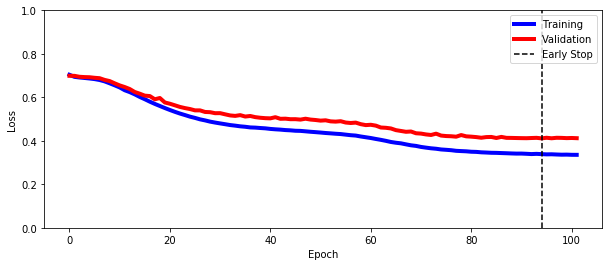

Test Set Performance:
Loss: 0.4036	Balanced Accuracy: 83.15%	 auROC: 0.894	 auPRC: 0.906
	Recall at 5%|10%|20% FDR: 59.2%|73.0%|84.6%	 Num Positives: 1966	 Num Negatives: 2034


In [11]:
#Define simulation parameters 
six5_parameters={
    "motif_name": "SIX5_known1",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
six5_data=get_simulation_data("simulate_single_motif_detection",
                               six5_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
six5_default_model,six5_default_history=train_default_model(six5_data,1)

### Motif Density Detection 

In this binary simulation task, we simulate 10K 500 bp random sequences with 0-2 instances of a TAL1 motif embedded at any random position and
10K 500 bp random sequences with 3-5 instances of the motif embedded at any random position. To solve this simulation, the model needs to learn the differences in motif counts.

In [12]:
print_simulation_info("simulate_motif_counting")



    Generates data for motif counting task.

    Parameters
    ----------
    motif_name : str
    seq_length : int
    pos_counts : list
        (min_counts, max_counts) for positive set.
    neg_counts : list
        (min_counts, max_counts) for negative set.
    num_pos : int
    num_neg : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darray
        Contains labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


In [ ]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_detection_default_model,density_detection_default_history=train_default_model(density_detection_data,1)

Training Data:
Loss: 0.6869	Balanced Accuracy: 54.52%	 auROC: 0.563	 auPRC: 0.551
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6339	 Num Negatives: 6461
Validation Data:
Loss: 0.6890	Balanced Accuracy: 54.20%	 auROC: 0.552	 auPRC: 0.557
	Recall at 5%|10%|20% FDR: 0.4%|0.7%|0.8%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6540	Balanced Accuracy: 64.28%	 auROC: 0.737	 auPRC: 0.729
	Recall at 5%|10%|20% FDR: 1.2%|7.8%|30.1%	 Num Positives: 6339	 Num Negatives: 6461
Validation Data:
Loss: 0.6580	Balanced Accuracy: 62.02%	 auROC: 0.709	 auPRC: 0.710
	Recall at 5%|10%|20% FDR: 0.5%|3.0%|24.3%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.5755	Balanced Accuracy: 78.42%	 auROC: 0.873	 auPRC: 0.872
	Recall at 5%|10%|20% FDR: 28.3%|51.0%|76.1%	 Num Positives: 6339	 Num Negatives: 6461
Validation Data:
Loss: 0.5826	Balanced Accuracy: 76.39%	 auROC: 0.858	 auPRC: 0.862
	Recall at 5%|10%|20% FDR: 34.8%|49.3%|72.3%	 Num Positives: 1617	 Num Negati

Training Data:
Loss: 0.2045	Balanced Accuracy: 91.67%	 auROC: 0.976	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 86.4%|93.0%|98.1%	 Num Positives: 6339	 Num Negatives: 6461
Validation Data:
Loss: 0.2197	Balanced Accuracy: 90.57%	 auROC: 0.971	 auPRC: 0.973
	Recall at 5%|10%|20% FDR: 83.9%|91.2%|97.7%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.2071	Balanced Accuracy: 91.38%	 auROC: 0.976	 auPRC: 0.976
	Recall at 5%|10%|20% FDR: 86.7%|93.2%|98.0%	 Num Positives: 6339	 Num Negatives: 6461
Validation Data:
Loss: 0.2218	Balanced Accuracy: 90.20%	 auROC: 0.971	 auPRC: 0.973
	Recall at 5%|10%|20% FDR: 83.8%|91.4%|97.6%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.2009	Balanced Accuracy: 91.86%	 auROC: 0.977	 auPRC: 0.977
	Recall at 5%|10%|20% FDR: 86.9%|93.3%|98.1%	 Num Positives: 6339	 Num Negatives: 6461
Validation Data:
Loss: 0.2177	Balanced Accuracy: 90.72%	 auROC: 0.971	 auPRC: 0.973
	Recall at 5%|10%|20% FDR: 84.0%|91.3%|97.6%	 Num Positives: 1617	 

### Motif Density Localization 

In this binary simulation task, we simulate 20K random sequences of length 1 Kbp with 2-4 embedded instances of the TAL1 motif. In the positive set of 10K sequences, the motif instances are embedded in the central 150bp. The negative set of 10K sequences, contain embedded motif instances at any random position. To solve this simulation, the model needs to learn localization differences of the motif instances.

In [ ]:
print_simulation_info("simulate_motif_density_localization")


In [ ]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_localization_default_model,density_localization_default_history=train_default_model(density_localization_data,1)

### Multiple Motif Detection 

In this simulation of multiple co-binding TFs, we simulate 20K 500 bp random sequences. For each sequence, we independently embed 0 or 1 instance of motifs corresponding to 3 TFs: CTCF, ZNF143, and SIX5 (See SM). Each sequence has binary labels for 3 tasks corresponding to the presence/absence of a motif instance of each of the three TFs. We train a multitask CNN such as that the last layer of the model now has three output logistic neurons corresponding to the three separate tasks. To solve this simulation, the model needs to detect all three motifs while sharing parameters.

In [ ]:
print_simulation_info("simulate_multi_motif_embedding")


In [ ]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
multi_motif_default_model,multi_motif_default_history=train_default_model(multi_motif_data,3)

### Heterodimer Motif Grammar 

In this binary simulation task, we simulate 20K 500 bp random sequences with one instance of an SPI1 motif and one instance of an IRF motif. In the positive set of 10K sequences, the pair of motifs are embedded with a relative spacing of 2-5 bp between each other, at any random position in each sequence. In the negative set, the pair of motifs are both randomly embedded with no positional or spacing constraints. 

In [ ]:
print_simulation_info("simulate_heterodimer_grammar")

In [ ]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

To solve this simulation, the model needs to detect both motifs and learn the spacing constraint between them in the positive set. For this simulation, an architecture with a single convolutional layer does not perform well. Hence, we use a reference architecture with 3 convolutional layers. Each convolutional layer has 15 filters (size 15, stride 1) and ReLU-non-linearity, followed by max-pooling (size 35, stride 35), followed by a fully connected layer with sigmoid non-linearity for binary classification.

In [ ]:
def build_heterodimer_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))    
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model


#Train default model 
heterodimer_default_model,heterodimer_default_history=train_default_model(heterodimer_data,1,build_heterodimer_model)

Let's store the datasets we have generated in a dictionary to facilitate hyperparameter grid search: 

In [ ]:
datasets=dict() 
datasets['SingleMotif_TAL1']=tal1_data 
datasets['DensityDetection']=density_detection_data
datasets['DensityLocalization']=density_localization_data 
datasets['MultipleMotifDetection']=multi_motif_data
datasets['HeterodimerGrammar']=heterodimer_data  

dataset_names=["SingleMotif_TAL1","DensityDetection","DensityLocalization","MultipleMotifDetection","HeterodimerGrammar"]


## Hyperparameter Grid Search

We now systematically vary the number of training examples, size of convolutional filters, number of convolutional filters and size of max pooling to understand the impact of these hyperparameters on prediction performance for each of the simulations.

DragoNN provides several helper functions to perform the hyperparameter grid search 

In [ ]:
from dragonn.hyperparameter_search_tutorial import * 

Note: for purposes of this tutorial, we set the training defaults at  150 epochs with a patience threshold of 7. These values can be passed as arguments to the function "hyperparam_train_model" if you would like to use lower values (for faster training) or higher values (to increase confidence that the loss is not stuck at a local minimum). 

In [ ]:
help(hyperparam_get_model)

In [ ]:
help(hyperparam_train_model)

### Training examples

In [ ]:
#Define grid of possible parameter values 
training_examples_grid=range(500,13000,1000)

training_examples_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    training_examples_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for num_training_examples in training_examples_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                               num_layers=3,
                                               num_filters=15)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::])
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model,num_training_examples=num_training_examples)
        print("Number of training examples:"+str(num_training_examples)+": auPRC:"+str(cur_auPRC))
        training_examples_test_auPRC[name].append(cur_auPRC)
    
    

Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(training_examples_grid,
                           training_examples_test_auPRC,
                           "No. Training Examples",
                           "test auPRC")


### Convolutional Filter Width


In [ ]:
#Define grid of possible parameter values 
filter_width_grid=range(1,31,5)

filter_width_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    filter_width_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for filter_width in filter_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=15,
                                            kernel_size=filter_width)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3,
                                          kernel_size=filter_width)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          kernel_size=filter_width)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Filter width:"+str(filter_width)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)
    
   

Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(filter_width_grid,
                           filter_width_test_auPRC,
                           "Filter Width",
                           "test auPRC")

### Number of convolution filters


In [ ]:
#Define grid of possible parameter values 
num_filters_grid=range(1,40,5)

num_filters_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    num_filters_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for num_filters in filter_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=num_filters)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_tasks=3,
                                            num_filters=num_filters)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          num_filters=num_filters)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Number of Conv. Filters:"+str(num_filters)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)

Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(num_filters_grid,
                           num_filters_test_auPRC,
                           "Number of Convolution Filters",
                           "test auPRC")

### Max Pooling Width

In [ ]:
#Define grid of possible parameter values 
pool_width_grid=range(5,55,10)

pool_width_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    pool_width_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for pool_width in pool_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=15,
                                            pool_size=pool_width)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3,
                                          pool_size=pool_width)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          pool_size=pool_width)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Max Pool Size:"+str(pool_width)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)

Plot the results of the parameter grid search:

In [ ]:
hyperparam_plot_test_auPRC(pool_width_grid,
                           pool_width_test_auPRC,
                           "Max Pool Width",
                           "test auPRC")

## Conclusions<a name='5'>
<a href=#outline>Home</a>

* To fully convince ourselves that the hyperparameters we have found for each dataset are truly optimal, we should repeat this experiment several times and use the average test auPRC for each hyperparameter setting. What happens if your run each parameter tuning step 5 times? 10 times? Do the optimal parameter values we have found  hold?


* We performed parameter grid search "manually" to illustrate how this process works. However, a number of Python packages are available to automate this task. A few notable ones are: 

     * Hyperas (https://github.com/maxpumperla/hyperas)
     * Hyperopt (https://github.com/hyperopt/hyperopt)  
     * MOE (https://github.com/Yelp/MOE) 